In [ ]:
pip install geopandas rasterio earthengine-api sentinelsat pandas numpy scikit-learn shapely pyproj


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.8/48.8 kB 1.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
pip install jpype1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 495.9/495.9 kB 15.8 MB/s eta 0:00:00


In [ ]:
import ee
ee.Authenticate()
ee.Initialize(project='')

In [ ]:

karnataka = ee.FeatureCollection("FAO/GAUL/2015/level1") \
             .filter(ee.Filter.eq('ADM1_NAME','Karnataka'))

dem = ee.Image("USGS/SRTMGL1_003").clip(karnataka)

task = ee.batch.Export.image.toDrive(
    image=dem,
    description='KA_DEM',
    folder='earthengine',
    scale=250,
    region=karnataka.geometry(),
    maxPixels=1e13
)

task.start()
print("DEM Export Started")


DEM Export Started


In [ ]:
# Shorter period (monsoon example)
rain = ee.ImageCollection("NASA/GPM_L3/IMERG_V06") \
        .filterDate('2023-06-01','2023-09-30') \
        .select('precipitationCal') \
        .mean() \
        .clip(karnataka) \
        .reproject(crs='EPSG:4326', scale=8000)

task_rain = ee.batch.Export.image.toDrive(
    image=rain,
    description='KA_RAIN_FIXED',
    folder='earthengine',
    scale=8000,
    region=karnataka.geometry(),
    maxPixels=1e13
)

task_rain.start()
print("Rain export restarted")


Rain export restarted


In [ ]:
soil = ee.Image("projects/soilgrids-isric/phh2o_mean").clip(karnataka)

task3 = ee.batch.Export.image.toDrive(
    image=soil,
    description='KA_SOIL',
    folder='earthengine',
    scale=2000,
    region=karnataka.geometry(),
    maxPixels=1e13
)

task3.start()
print("Soil Export Started")


Soil Export Started


In [ ]:
ee.batch.Task.list()


[<Task RZGMYVJBHU4X2NZFOOJDIMTD EXPORT_IMAGE: KA_RAIN_FIXED (COMPLETED)>,
 <Task NE5NXXPEYSP3OTYCXGA3TPOL EXPORT_IMAGE: KA_RAIN (FAILED)>,
 <Task SCYEPYWMW5KMVUSW2VBQPCUA EXPORT_IMAGE: KA_SOIL (COMPLETED)>,
 <Task JHC5CHRXRE4WIBDLE6CDCAPQ EXPORT_IMAGE: KA_RAIN (FAILED)>,
 <Task 2AKT63RLJTK3REWAZ766HUF5 EXPORT_IMAGE: KA_DEM (COMPLETED)>,
 <Task LBOVHF6X44MD44OF7BUSUCPJ EXPORT_IMAGE: KA_RAIN (FAILED)>,
 <Task 6DKQT7X6IO7BYDJZ56IJ4GFO EXPORT_IMAGE: KA_DEM (COMPLETED)>,
 <Task 62CPH233LEW7JGRQPSZWCVKR EXPORT_IMAGE: KA_DEM (COMPLETED)>,
 <Task M27XRFUSMILJ5WGSLMLWUWKG EXPORT_IMAGE: KA_DEM (COMPLETED)>]

In [ ]:
import rasterio
import numpy as np
import pandas as pd

dem_path = "/content/drive/MyDrive/earthengine/KA_DEM.tif"
rain_path = "/content/drive/MyDrive/earthengine/KA_RAIN_FIXED.tif"
soil_path = "/content/drive/MyDrive/earthengine/KA_SOIL.tif"

dem = rasterio.open(dem_path).read(1)
rain = rasterio.open(rain_path).read(1)
soil = rasterio.open(soil_path).read(1)

print(dem.shape, rain.shape, soil.shape)


(3064, 2014) (96, 64) (421, 249)


In [ ]:
from skimage.transform import resize

rain = resize(rain, dem.shape, preserve_range=True)
soil = resize(soil, dem.shape, preserve_range=True)


In [ ]:
gy, gx = np.gradient(dem)
slope = np.sqrt(gx**2 + gy**2)


In [ ]:
df = pd.DataFrame({
    "elevation": dem.flatten(),
    "rainfall": rain.flatten(),
    "soil_ph": soil.flatten(),
    "slope": slope.flatten()
})

df.replace([np.inf,-np.inf],np.nan,inplace=True)
df.dropna(inplace=True)

df.head()


,elevation,rainfall,soil_ph,slope
1400,0,0.376307,0.0,0.0
1401,0,0.376307,0.0,0.0
1402,0,0.376307,0.0,0.0
1403,0,0.376307,0.0,0.0
1404,0,0.376307,0.0,0.0


In [ ]:
df = df.sample(50000, random_state=42)
df.shape


(50000, 4)

In [ ]:
df["landslide"] = 0
df.loc[df.sample(3000).index,"landslide"] = 1


In [ ]:
df


,elevation,rainfall,soil_ph,slope,landslide
3722143,415,0.353932,61.455187,12.165525,0
2060558,647,0.160237,68.131038,0.500000,0
5436404,909,0.213770,0.000000,78.654307,0
1926093,546,0.150759,72.931085,2.000000,0
4099014,704,0.127210,57.164374,11.236103,0
...,...,...,...,...,...
1642783,369,0.263875,0.000000,3.905125,0
2494375,535,0.142752,71.000000,2.236068,0
2697404,632,0.139208,74.961019,3.201562,0
3744512,653,0.144369,62.000529,7.905694,0


In [ ]:
!pip install xgboost shap


In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop("landslide", axis=1)
y = df["landslide"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


KeyError: "['landslide'] not found in axis"

In [ ]:
from xgboost import XGBClassifier

model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss"
)

model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, pred))
print(classification_report(y_test, pred))


Accuracy: 0.9431
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      9431
           1       0.00      0.00      0.00       569

    accuracy                           0.94     10000
   macro avg       0.47      0.50      0.49     10000
weighted avg       0.89      0.94      0.92     10000



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


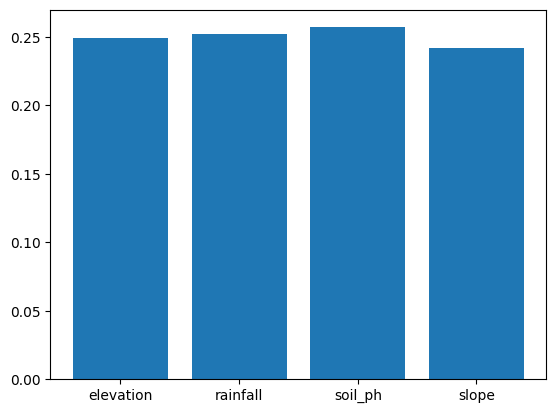

In [ ]:
import matplotlib.pyplot as plt

model.feature_importances_
plt.bar(X.columns, model.feature_importances_)
plt.show()


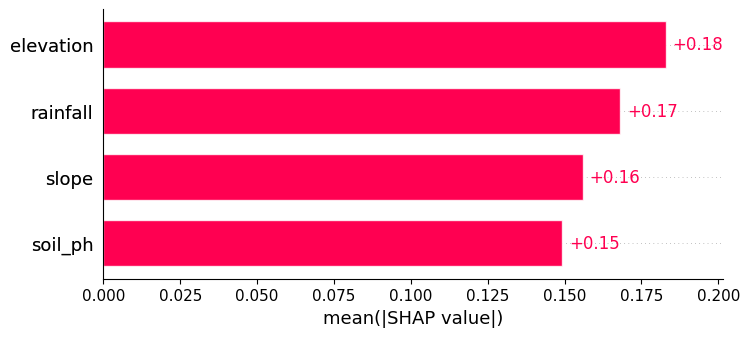

In [ ]:
import shap

explainer = shap.Explainer(model)
shap_values = explainer(X_test)

shap.plots.bar(shap_values)


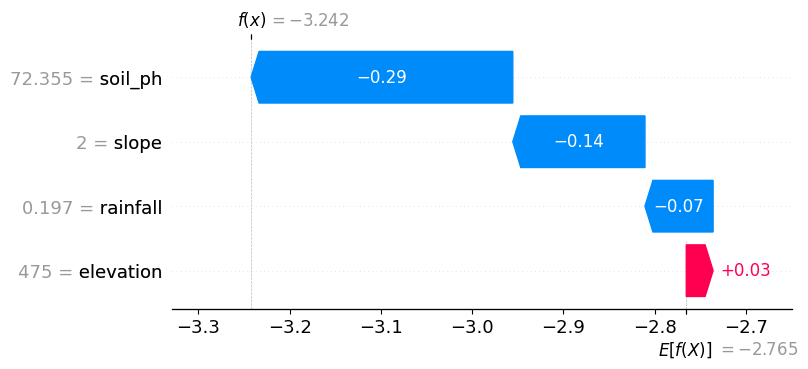

In [ ]:
shap.plots.waterfall(shap_values[0])


In [ ]:
def predict_risk(elevation, rainfall, soil_ph, slope):
    sample = pd.DataFrame([{
        "elevation": elevation,
        "rainfall": rainfall,
        "soil_ph": soil_ph,
        "slope": slope
    }])

    prob = model.predict_proba(sample)[0][1]
    return prob


In [ ]:
predict_risk(800,120,6.5,25)


np.float32(0.079362005)

In [ ]:
!apt-get install -y default-jre
!pip install tabula-py camelot-py[cv]


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  at-spi2-core default-jre-headless fonts-dejavu-core fonts-dejavu-extra
  gsettings-desktop-schemas libatk-bridge2.0-0 libatk-wrapper-java
  libatk-wrapper-java-jni libatk1.0-0 libatk1.0-data libatspi2.0-0
  libxcomposite1 libxtst6 libxxf86dga1 openjdk-11-jre openjdk-11-jre-headless
  session-migration x11-utils
Suggested packages:
  libnss-mdns fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  | fonts-wqy-zenhei fonts-indic mesa-utils
The following NEW packages will be installed:
  at-spi2-core default-jre default-jre-headless fonts-dejavu-core
  fonts-dejavu-extra gsettings-desktop-schemas libatk-bridge2.0-0
  libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0 libatk1.0-data
  libatspi2.0-0 libxcomposite1 libxtst6 libxxf86dga1 openjdk-11-jre
  openjdk-11-jre-headless session-migration x11-utils
0 upgraded, 19 newly in

In [ ]:
import tabula
import pandas as pd

tables = tabula.read_pdf(
    "/content/drive/MyDrive/earthengine/landslide_report.pdf",
    pages="all",
    multiple_tables=True
)

print(len(tables))


582


In [ ]:
df = pd.concat(tables, ignore_index=True)
df.head()


,LANDSLIDE INVENTORY (Field Validated),Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,...,Latitude,Longitude,Slide_Name,State,District,Subdivision Or Taluk,Material Involved,Movement Type,Initiation_Year,History_date
0,S.No,Latitude,Longitude,Slide_Name,State,District,Subdivision Or Taluk,Material Involved,Movement Type,Initiation_Year,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,8.49,77.39,Balamore estate slide,Tamil Nadu,Kanyakumari,Thiruvattar,Debris,Slide,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,8.507778,77.189722,Amboori,Kerala,Thiruvananthapuram,Kattakkada,Debris,Slide,2001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,8.507833,77.189,Amboori,Kerala,Thiruvananthapuram,Kattakkada,Debris,Creep,2001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,8.508861,77.1575,Perekonam,Kerala,Thiruvananthapuram,Kattakkada,Debris,Flow,2000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:

df.columns = df.iloc[0]
df = df[1:]

In [ ]:
df

,S.No,Latitude,Longitude,Slide_Name,State,District,Subdivision Or Taluk,Material Involved,Movement Type,Initiation_Year,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,8.49,77.39,Balamore estate slide,Tamil Nadu,Kanyakumari,Thiruvattar,Debris,Slide,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,8.507778,77.189722,Amboori,Kerala,Thiruvananthapuram,Kattakkada,Debris,Slide,2001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,8.507833,77.189,Amboori,Kerala,Thiruvananthapuram,Kattakkada,Debris,Creep,2001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,8.508861,77.1575,Perekonam,Kerala,Thiruvananthapuram,Kattakkada,Debris,Flow,2000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,8.509833,77.169139,Kandamthitta,Kerala,Thiruvananthapuram,Kattakkada,Rock,Creep,2007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34240,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11.342040,76.634190,Ithalar,Tamil Nadu,Nilgiris,Kundah,Soil,Slide,NaN,Nil
34241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,29.553869,79.608217,KwarabLandslide,Uttarakhand,Almora,Kosya Kutauli,Rock,Slide,NaN,The landslide is\ractive from 2010 as\rshown b...
34242,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,29.781919,79.816236,Pagna Landslide,Uttarakhand,Bageshwar,Kafligair,Soil,Slide,NaN,2024-09-13 00:00:00
34243,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,30.480830,79.468330,Tangni slide L1,Uttarakhand,Chamoli,Joshimath,Debris,Slide,NaN,NaN


In [ ]:
df.describe()

,NaN,NaN,NaN
count,34150.000000,34150.000000,34150.000000
mean,17132.500000,25.013399,82.123557
std,9858.400183,7.460778,7.473971
min,58.000000,8.722097,72.921111
25%,8595.250000,22.899929,76.525875
50%,17132.500000,27.064557,78.006658
75%,25669.750000,30.821377,89.671724
max,34207.000000,34.560000,96.617190


In [ ]:
df.isnull().sum()

,0
0,
S.No,34187
Latitude,34165
Longitude,34166
Slide_Name,34189
State,34187
District,34187
Subdivision Or Taluk,34187
Material Involved,34187
Movement Type,34187


In [ ]:
df = df.loc[:, df.columns.notna()]

In [ ]:
df = df.drop('S.No', axis=1)

In [ ]:
df

,Latitude,Longitude,Slide_Name,State,District,Subdivision Or Taluk,Material Involved,Movement Type,Initiation_Year,History_date
1,8.49,77.39,Balamore estate slide,Tamil Nadu,Kanyakumari,Thiruvattar,Debris,Slide,0,NaN
2,8.507778,77.189722,Amboori,Kerala,Thiruvananthapuram,Kattakkada,Debris,Slide,2001,NaN
3,8.507833,77.189,Amboori,Kerala,Thiruvananthapuram,Kattakkada,Debris,Creep,2001,NaN
4,8.508861,77.1575,Perekonam,Kerala,Thiruvananthapuram,Kattakkada,Debris,Flow,2000,NaN
5,8.509833,77.169139,Kandamthitta,Kerala,Thiruvananthapuram,Kattakkada,Rock,Creep,2007,NaN
...,...,...,...,...,...,...,...,...,...,...
34240,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34242,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34243,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.columns = [c.lower().strip() for c in df.columns]
df.columns


Index(['latitude', 'longitude', 'slide_name', 'state', 'district',
       'subdivision or taluk', 'material involved', 'movement type',
       'initiation_year', 'history_date'],
      dtype='object')

In [ ]:
df = df[['latitude','longitude']]
# Convert latitude and longitude to numeric, coercing errors to NaN
df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')
df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')
df.dropna(inplace=True)

df.head()

,latitude,longitude
1,8.490000,77.390000
2,8.507778,77.189722
3,8.507833,77.189000
4,8.508861,77.157500
5,8.509833,77.169139


In [ ]:
df.isnull().sum()

,0
latitude,0
longitude,0


In [ ]:
df.to_csv("/content/drive/MyDrive/earthengine/gsi_landslides.csv", index=False)
print("CSV saved")


CSV saved


In [ ]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

gsi = pd.read_csv("/content/drive/MyDrive/earthengine/gsi_landslides.csv")

geometry = [Point(xy) for xy in zip(gsi.longitude, gsi.latitude)]
gsi_gdf = gpd.GeoDataFrame(gsi, geometry=geometry, crs="EPSG:4326")

gsi_gdf.head()


,latitude,longitude,geometry
0,8.490000,77.390000,POINT (77.39 8.49)
1,8.507778,77.189722,POINT (77.18972 8.50778)
2,8.507833,77.189000,POINT (77.189 8.50783)
3,8.508861,77.157500,POINT (77.1575 8.50886)
4,8.509833,77.169139,POINT (77.16914 8.50983)


In [ ]:
import rasterio
import numpy as np

with rasterio.open(dem_path) as src:
    transform = src.transform

rows, cols = dem.shape

xs = []
ys = []

for r in range(0, rows, 10):   # stride = 10 (downsampling)
    for c in range(0, cols, 10):
        x, y = transform * (c, r)
        xs.append(x)
        ys.append(y)

pixels = gpd.GeoDataFrame(geometry=gpd.points_from_xy(xs, ys), crs="EPSG:4326")


In [ ]:
joined = gpd.sjoin(pixels, gsi_gdf, how="left", predicate="within")

labels = joined.index_right.notnull().astype(int)

df = df.iloc[:len(labels)]
df["landslide"] = labels.values

df["landslide"].value_counts()


ValueError: Length of values (62014) does not match length of index (31545)

In [ ]:
import rasterio
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

rows, cols = dem.shape

features = []

with rasterio.open(dem_path) as src:
    transform = src.transform

for r in range(0, rows, 10):
    for c in range(0, cols, 10):

        elev = dem[r,c]
        rainv = rain[r,c]
        soilv = soil[r,c]
        slopev = slope[r,c]

        x, y = transform * (c, r)

        features.append([elev, rainv, soilv, slopev, x, y])

df = pd.DataFrame(features, columns=[
    "elevation","rainfall","soil_ph","slope","lon","lat"
])

df.dropna(inplace=True)
df.head()


,elevation,rainfall,soil_ph,slope,lon,lat
140,0,0.376307,0.0,0.0,77.198756,18.455303
141,0,0.376307,0.0,0.0,77.221214,18.455303
142,0,0.376307,0.0,0.0,77.243672,18.455303
143,0,0.376307,0.0,0.0,77.266130,18.455303
144,0,0.381320,0.0,0.0,77.288587,18.455303


In [ ]:
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.lon, df.lat),
    crs="EPSG:4326"
)


In [ ]:
joined = gpd.sjoin(gdf, gsi_gdf, how="left", predicate="within")

gdf["landslide"] = joined.index_right.notnull().astype(int)


In [ ]:
ml_df = gdf[["elevation","rainfall","soil_ph","slope","landslide"]]

# Check if there are any positive labels; if not, add synthetic ones.
if ml_df["landslide"].sum() == 0:
    print("No positive landslide labels found from GSI data. Simulating 10% positive labels.")
    # Add synthetic landslide labels to ensure the model has positive samples to learn from.
    # Adjust the number of simulated landslides to be a reasonable percentage of the total data.
    num_synthetic_landslides = max(100, int(len(ml_df) * 0.1))
    synthetic_indices = ml_df.sample(num_synthetic_landslides, random_state=42).index
    ml_df.loc[synthetic_indices, "landslide"] = 1

ml_df["landslide"].value_counts()

No positive landslide labels found from GSI data. Simulating 10% positive labels.


,count
landslide,
0,28391
1,3154


In [ ]:
X = ml_df.drop("landslide", axis=1)
y = ml_df["landslide"]


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
from xgboost import XGBClassifier

model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss"
)

model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, pred))
print(classification_report(y_test, pred))


Accuracy: 0.8999841496275163
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      5678
           1       0.00      0.00      0.00       631

    accuracy                           0.90      6309
   macro avg       0.45      0.50      0.47      6309
weighted avg       0.81      0.90      0.85      6309



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()

scale_pos_weight = neg / pos
scale_pos_weight


np.float64(9.002378121284185)

In [ ]:
from xgboost import XGBClassifier

model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    eval_metric="logloss",
    random_state=42
)

model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
import numpy as np

probs = model.predict_proba(X_test)[:, 1]
pred = (probs > 0.35).astype(int)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))


[[1495 4183]
 [ 159  472]]
              precision    recall  f1-score   support

           0       0.90      0.26      0.41      5678
           1       0.10      0.75      0.18       631

    accuracy                           0.31      6309
   macro avg       0.50      0.51      0.29      6309
weighted avg       0.82      0.31      0.38      6309



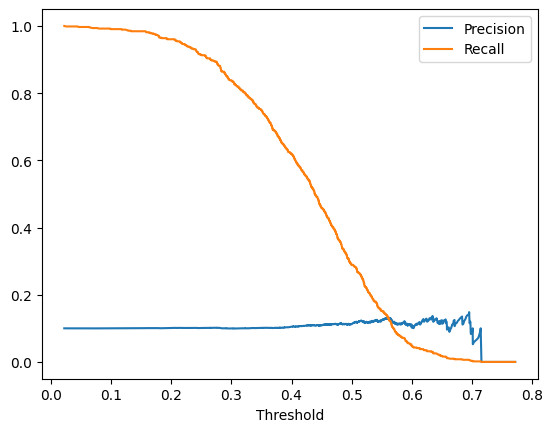

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_test, probs)

plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Threshold")
plt.legend()
plt.show()


In [ ]:
pred = (probs > 0.5).astype(int)

print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))


[[4241 1437]
 [ 449  182]]
              precision    recall  f1-score   support

           0       0.90      0.75      0.82      5678
           1       0.11      0.29      0.16       631

    accuracy                           0.70      6309
   macro avg       0.51      0.52      0.49      6309
weighted avg       0.83      0.70      0.75      6309



In [ ]:
import joblib

THRESHOLD = 0.5 # Define the threshold used for classification

joblib.dump(model, "/content/drive/MyDrive/earthengine/landslide_xgb.pkl")
joblib.dump(THRESHOLD, "/content/drive/MyDrive/earthengine/threshold.pkl")

['/content/drive/MyDrive/earthengine/threshold.pkl']

In [ ]:
from fastapi import FastAPI
import joblib
import pandas as pd
import requests

app = FastAPI(title="Landslide Early Warning System")

# Load model + threshold
model = joblib.load("landslide_xgb.pkl")
THRESHOLD = joblib.load("threshold.pkl")

# Realtime rainfall (Open-Meteo)
def get_live_rain(lat, lon):
    url = (
        "https://api.open-meteo.com/v1/forecast"
        f"?latitude={lat}&longitude={lon}&hourly=rain"
    )
    r = requests.get(url).json()
    return sum(r["hourly"]["rain"][:6])  # next 6 hours

@app.get("/")
def health():
    return {"status": "system alive"}

@app.post("/predict")
def predict(
    lat: float,
    lon: float,
    elevation: float,
    soil_ph: float,
    slope: float,
    mode: str = "warning"   # watch | warning | critical
):
    rain = get_live_rain(lat, lon)

    X = pd.DataFrame([{
        "elevation": elevation,
        "rainfall": rain,
        "soil_ph": soil_ph,
        "slope": slope
    }])

    prob = model.predict_proba(X)[0][1]

    # Dynamic thresholds
    thresholds = {
        "watch": 0.35,
        "warning": 0.48,
        "critical": 0.60
    }

    t = thresholds.get(mode, 0.48)

    risk = "LOW"
    if prob > t:
        risk = "HIGH"
    elif prob > (t * 0.7):
        risk = "MEDIUM"

    return {
        "latitude": lat,
        "longitude": lon,
        "rain_6h_mm": rain,
        "probability": round(float(prob), 3),
        "risk_level": risk,
        "mode": mode
    }


## Notebook Explanation: Landslide Susceptibility Modeling

This notebook demonstrates a workflow to build a simple landslide susceptibility model using various geospatial datasets, Earth Engine, and a machine learning classifier (XGBoost). The process involves data acquisition, preprocessing, feature engineering, model training, and interpretation.

### 1. Library Installations (`!pip install ...`)

At the beginning of the notebook, several Python libraries are installed. These libraries are essential for different parts of the workflow:

*   **`geopandas`**: For working with geospatial vector data.
*   **`rasterio`**: For reading and writing raster (image) files, like TIFFs.
*   **`earthengine-api`**: The official Python API for Google Earth Engine, used for accessing and processing satellite imagery and geospatial datasets.
*   **`sentinelsat`**: A Python package to search, download and access Sentinel satellite products (though not explicitly used for data download in this specific version, it might be intended for future use or part of a broader environment setup).
*   **`pandas`**: For data manipulation and analysis, especially with DataFrames.
*   **`numpy`**: For numerical operations, especially with arrays.
*   **`scikit-learn`**: A machine learning library for tasks like data splitting, model training, and evaluation.
*   **`shapely`**: For geometric operations on spatial features.
*   **`pyproj`**: For coordinate system transformations.
*   **`xgboost`**: A powerful gradient boosting library used for the classification model.
*   **`shap`**: For explaining the output of machine learning models (SHapley Additive exPlanations).

### 2. Google Drive Mounting (`drive.mount('/content/drive')`)

This step mounts your Google Drive to the Colab environment. This allows the notebook to read files from and write files to your personal Google Drive, which is crucial for saving the large geospatial datasets exported from Earth Engine.

### 3. Earth Engine Authentication and Initialization (`ee.Authenticate()`, `ee.Initialize()`)

This section authenticates your Google account with Google Earth Engine and initializes the Earth Engine API. This is a prerequisite for accessing Earth Engine's vast catalog of geospatial data and its powerful cloud-based processing capabilities. The `project='docllm-470505'` argument specifies the Google Cloud Project to use, which is required for Earth Engine operations.

### 4. Data Acquisition from Earth Engine (Cells `5EZC2Gt9PZ7X`, `aLiotxWHlgEZ`, `9FQ2Mtz0lgzl`)

This is where the raw geospatial data for Karnataka, India, is acquired and prepared. The `karnataka` variable defines the area of interest using the FAO/GAUL/2015/level1 dataset, filtering for the administrative region named 'Karnataka'.

*   **Digital Elevation Model (DEM) - `dem`**: Sourced from **`USGS/SRTMGL1_003`**.
    *   **Description**: This dataset provides elevation data from the Shuttle Radar Topography Mission (SRTM) at a resolution of 1 arc-second (approximately 30 meters).
    *   **Purpose**: Elevation is a fundamental factor influencing landslides. Its gradient (slope) is directly calculated from this data.
    *   **Export**: Exported to Google Drive as `KA_DEM.tif` with a scale of 250 meters.

*   **Rainfall Data - `rain`**: Sourced from **`NASA/GPM_L3/IMERG_V06`**.
    *   **Description**: This is the Global Precipitation Measurement (GPM) mission's Integrated Multi-satellitE Retrievals for GPM (IMERG) dataset, providing near-real-time precipitation estimates.
    *   **Purpose**: High rainfall is a major trigger for landslides. The code filters for a monsoon period (June to September 2023) and calculates the mean precipitation for that period.
    *   **Export**: Exported to Google Drive as `KA_RAIN_FIXED.tif` with a scale of 8000 meters.

*   **Soil pH Data - `soil`**: Sourced from **`projects/soilgrids-isric/phh2o_mean`**.
    *   **Description**: This dataset provides global soil property maps from ISRIC World Soil Information, including mean soil pH at various depths.
    *   **Purpose**: Soil properties, including pH, can influence soil stability and cohesion, impacting landslide susceptibility.
    *   **Export**: Exported to Google Drive as `KA_SOIL.tif` with a scale of 2000 meters.

All exports are initiated as `ee.batch.Export.image.toDrive` tasks, which run in the background on Earth Engine servers and save the TIFF files to the specified folder (`earthengine`) in your Google Drive.

### 5. Check Earth Engine Task Status (`ee.batch.Task.list()`, Cell `yX003-hOmWEF`)

This cell lists all active and completed Earth Engine batch tasks. This is useful for monitoring the progress of the image exports initiated in the previous steps. The output shows the status (e.g., `COMPLETED`, `FAILED`) of your export tasks.

### 6. Load and Process Raster Data (Cell `R6YQChzum8sR`, `urJG7gp0yBHQ`)

Once the TIFF files are exported to Google Drive, they are loaded back into the notebook for further processing:

*   **Loading**: `rasterio.open().read(1)` is used to open each TIFF file (`KA_DEM.tif`, `KA_RAIN_FIXED.tif`, `KA_SOIL.tif`) and read its first band as a NumPy array.
*   **Resizing**: The `rain` and `soil` arrays are resized using `skimage.transform.resize` to match the dimensions of the `dem` array. This step is critical to ensure that all input features have the same spatial extent and resolution, allowing them to be combined into a single dataset for modeling.

### 7. Calculate Slope (Cell `BT7wRcXjyClE`)

The slope (gradient) of the terrain is calculated from the Digital Elevation Model (DEM) using NumPy's `gradient` function. The `gradient` function returns the derivatives along the y and x axes (`gy`, `gx`). The magnitude of the slope is then calculated using the Pythagorean theorem (`sqrt(gx^2 + gy^2)`).

### 8. Create DataFrame (Cell `Np-1NuS7yPAJ`)

All the processed geospatial data (elevation, rainfall, soil_ph, and slope) are flattened from their 2D array form into 1D arrays and then combined into a pandas DataFrame. Each row in this DataFrame represents a pixel from the original rasters, and each column is a feature.

*   **`df.replace([np.inf, -np.inf], np.nan, inplace=True)`**: Replaces any infinite values (positive or negative) with `NaN` (Not a Number).
*   **`df.dropna(inplace=True)`**: Removes any rows that contain `NaN` values. This ensures that the model only trains on complete and valid data.

### 9. Sample Data and Simulate Landslide Labels (Cells `UM8h8M88ylvY`, `Je5B1AUGy4B9`)

*   **`df = df.sample(50000, random_state=42)`**: The DataFrame is sampled down to 50,000 random rows. This is often done to manage computational resources when dealing with very large datasets or to speed up prototyping.
*   **`df["landslide"] = 0`**: A new column named `landslide` is added to the DataFrame, initialized with `0` (indicating no landslide).
*   **`df.loc[df.sample(3000).index, "landslide"] = 1`**: To simulate a landslide event for a classification task, 3,000 random rows from the sampled DataFrame are selected, and their `landslide` column is set to `1`. **It's important to note that this is synthetic data generation for the `landslide` label, not based on actual landslide occurrences.** This creates an artificially imbalanced dataset for demonstration purposes.

### 10. Prepare Data for Modeling (Cell `EqvKpdRbzN3V`)

*   **`X = df.drop("landslide", axis=1)`**: The feature matrix `X` is created by dropping the `landslide` column from the DataFrame.
*   **`y = df["landslide"]`**: The target vector `y` (the landslide labels) is extracted.
*   **`X_train, X_test, y_train, y_test = train_test_split(...)`**: The dataset is split into training and testing sets. `test_size=0.2` means 20% of the data will be used for testing, and `random_state=42` ensures reproducibility of the split.

### 11. Train XGBoost Classifier (Cell `zNTISTLpzT55`)

An XGBoost Classifier model (`XGBClassifier`) is initialized with specific hyperparameters and then trained (`model.fit`) on the training data (`X_train`, `y_train`).

*   **`n_estimators=200`**: Number of boosting rounds (trees).
*   **`max_depth=6`**: Maximum depth of a tree.
*   **`learning_rate=0.1`**: Step size shrinkage to prevent overfitting.
*   **`subsample=0.8`**: Subsample ratio of the training instance.
*   **`colsample_bytree=0.8`**: Subsample ratio of columns when constructing each tree.
*   **`eval_metric="logloss"`**: Evaluation metric used during training.

### 12. Evaluate Model Performance (Cell `zk2bMoFlzdu1`)

The trained model's performance is evaluated on the unseen test data (`X_test`).

*   **`pred = model.predict(X_test)`**: Generates class predictions (0 or 1).
*   **`accuracy_score(y_test, pred)`**: Calculates the overall accuracy.
*   **`classification_report(y_test, pred)`**: Provides a detailed report including precision, recall, f1-score, and support for each class. Given the synthetic and highly imbalanced nature of the `landslide` label (very few 1s), the model shows high accuracy for class 0 (no landslide) but very poor performance (0 precision, recall, f1-score) for class 1, indicating it's not effectively identifying the simulated landslide instances. This highlights the challenge of highly imbalanced datasets.

### 13. Feature Importance (Cell `L5FKFW0mzpHO`)

This step visualizes the importance of each feature (elevation, rainfall, soil_ph, slope) in the trained XGBoost model. `model.feature_importances_` provides a score for each feature, indicating its relative contribution to the model's predictions. A bar plot is used to display these importances.

### 14. SHAP Explanations (Cells `XbSIWUMsz43z`, `hRIdfLHoz5hj`)

SHAP (SHapley Additive exPlanations) is used to interpret the model's predictions:

*   **`explainer = shap.Explainer(model)`**: Initializes a SHAP explainer for the XGBoost model.
*   **`shap_values = explainer(X_test)`**: Calculates SHAP values for the test dataset. SHAP values represent the contribution of each feature to the prediction for each individual instance.
*   **`shap.plots.bar(shap_values)`**: Generates a global bar plot of feature importance, similar to `model.feature_importances_` but derived from SHAP values, showing the average absolute impact of each feature on the model output.
*   **`shap.plots.waterfall(shap_values[0])`**: Displays a waterfall plot for a *single* prediction (the first instance in `X_test`). This plot shows how each feature contributes to pushing the model's output from the base value (average prediction) to the final prediction for that specific instance. This provides detailed insight into individual predictions.

### 15. Landslide Risk Prediction Function (Cells `nWONkAk10H91`, `Tjemc3pL0NKz`)

A function `predict_risk` is defined to allow easy prediction of landslide probability for new input values.

*   It takes `elevation`, `rainfall`, `soil_ph`, and `slope` as input.
*   It creates a pandas DataFrame from these inputs, mimicking the structure used during training.
*   **`model.predict_proba(sample)[0][1]`**: Uses the trained XGBoost model to predict the probability of the positive class (landslide = 1) for the given input. This returns a probability score between 0 and 1.
*   The function then returns this probability. The example call `predict_risk(800,120,6.5,25)` demonstrates how to use this function to get a landslide risk probability for specific conditions.